This notebook implements Norman's idea for finding weights to approximate the lookback distribution of positives and negatives.

We define the empirical CDF of both. Take the ratio between the two CDFs and use that as a `w` weight vector. Then we optimise the following:
$$
\left(\bar{F_t}(x) - \bar{F_o}(x) \right)^2,
$$
where 
- $\bar{F_t}(x)$ is the empirical CDF of the target distribution evaluated at the points within the positive lookback vector
- $\bar{F_o}(x)$ is the empirical CDF of the kernel density estimated positive lookback data with weights: $\beta+\alpha*w$.

So optmizing over $\alpha$ and $\beta$ should give us the optimal weights that will make the CDF of the positive and target lookback distributions as similar as possible.


In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.nonparametric.kde import KDEUnivariate

C:\Program Files\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Load and plot PDF of target and positives

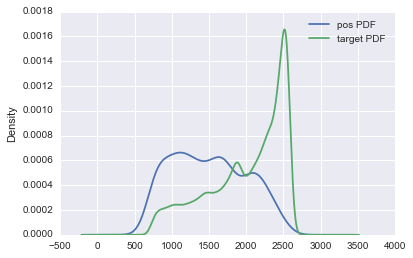

In [2]:
pos_df = pd.read_csv("../data/pos_train_data.csv")
scoring_lookback_df = pd.read_csv("../data/scoring_lookback.csv")
def plot_lookbacks(l1, l2, label1, label2):
    to_plot = pd.concat([l1, l2], axis=1)
    to_plot.columns = [label1, label2]
    to_plot.plot(kind="kde")
plot_lookbacks(pos_df.LOOKBACK, scoring_lookback_df.LOOKBACK, "pos PDF", "target PDF")

## Estimate empirical CDFs

In [3]:
pos = pos_df.LOOKBACK.values
target = scoring_lookback_df.LOOKBACK.values

In [4]:
ecdf_target = ECDF(target)
ecdf_target_pos_x = ecdf_target(pos)
ecdf_pos = ECDF(pos)
ecdf_pos_x = ecdf_pos(pos)
w = ecdf_target_pos_x / ecdf_pos_x

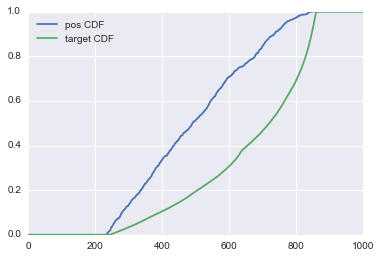

In [5]:
x = np.linspace(0, 3000, 1000)
ecdfs = list(zip(ecdf_pos(x), ecdf_target(x)))
ecdfs = pd.DataFrame(ecdfs, columns=["pos CDF", "target CDF"])
ecdfs.plot()

## Optimize the difference between two cdfs

## Unconstrained optimisation produces better estiamtes
This results in a negative beta which makes some weights negative, so we have to fix those manually, however the contrained optimisation methods do not move alpha and beta all.

In [7]:
def get_new_cdf(alpha, beta):
    weights_updated = beta + alpha * w
    kde_pos.fit(weights=weights_updated, fft=False)
    return kde_pos.cdf

def cost(x):
    new_cdf = get_new_cdf(x[0], x[1])
    target_cdf = ecdf_target(pos)
    return np.sum((target_cdf - new_cdf)**2)

# define Guassian Kernel Density Estimator on the positive lookbacks
kde_pos = KDEUnivariate(pos)
x0 = [1, 0]
alpha, beta = sp.optimize.fmin(cost, x0)

C:\Program Files\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Optimization terminated successfully.
         Current function value: 206.915732
         Iterations: 89
         Function evaluations: 178


## Let's try constraining alpha and beta
Unfortunately this doesn't really work for some reason and the optimiser is stuck at the initialisation point

In [6]:
# optimize alpha and beta
alpha_bounds = (0, None)
beta_bounds = (0, None)
bounds = [alpha_bounds, beta_bounds]
alpha, beta = sp.optimize.fmin_tnc(cost, x0, bounds=bounds, approx_grad=True)[0]

KeyboardInterrupt: 

Norman's 2nd idea was to push the weights through a sigmoid function to enforce their positivity. This takes ages to run and doesn't really give better results than the unconstrained version.

In [270]:
def update_weights(alpha, beta):
    return sp.stats.logistic.pdf(beta + w * alpha)

def get_new_cdf(alpha, beta):
    weights_updated = update_weights(alpha, beta)
    kde_pos.fit(weights=weights_updated, fft=False)
    return kde_pos.cdf

def cost(x):
    new_cdf = get_new_cdf(x[0], x[1])
    target_cdf = ecdf_target(pos)
    return np.sum((target_cdf - new_cdf)**2)

# define Guassian Kernel Density Estimator on the positive lookbacks
kde_pos = KDEUnivariate(pos)
# optimize alpha and beta
x0 = [1, 0]
alpha, beta = sp.optimize.fmin(cost, x0, disp=True, maxiter=100, retall =True)

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:375: RuntimeWarning: invalid value encountered in true_divide
  dens = np.dot(k,weights)/(q*bw)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:159: RuntimeWarning: invalid value encountered in true_divide
  self.kernel.weights /= weights.sum()
C:\Program Files\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Optimization terminated successfully.
         Current function value: 147.754332
         Iterations: 86
         Function evaluations: 207


#### Let's see if the two CDF's became more similar

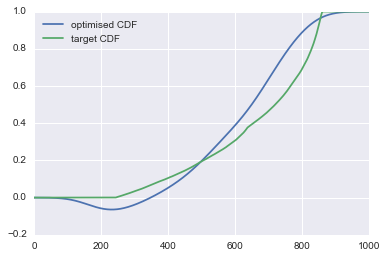

In [10]:
optimised_cdf = get_new_cdf(alpha, beta)
optimised_cdf
pd.DataFrame(list(zip(optimised_cdf, ecdf_target(x))), columns=["optimised CDF", "target CDF"]).plot()

How about the PDFs?

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


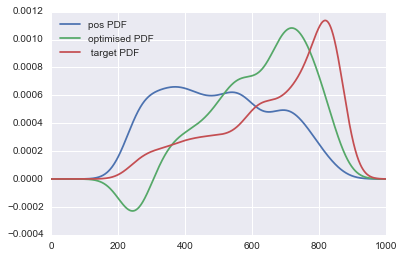

In [38]:
# let's estimate the PDF of the downsampled target. Downsampling due to out of memory errors
kde_target = KDEUnivariate(np.random.choice(target, 2000))
kde_target.fit(fft=True)
kde_pos_orig = KDEUnivariate(pos)
kde_pos_orig.fit(fft=True)
w_updated = beta + alpha * w 

kde_pos.fit(weights=w_updated, fft=False)

pdfs = [pd.Series(kde_pos_orig.evaluate(x)), pd.Series(kde_pos.evaluate(x)), pd.Series(kde_target.evaluate(x))]
pdfs = pd.concat(pdfs, axis=1)
pdfs.columns = ["pos PDF", "optimised PDF", " target PDF"]
pdfs.plot()

## Fix negative weights
As we can see, some of the negative weights make the optimised PDF turn negative, which should not happen. So we will set those negative weights to a small positive number. 

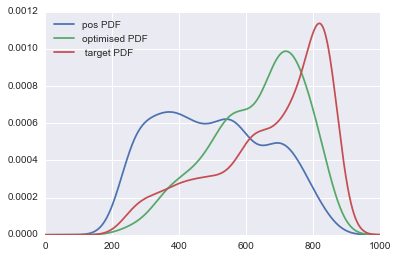

In [39]:
w_corrected = w_updated
w_corrected[w_corrected < 0] = .0001
kde_pos.fit(weights=w_corrected, fft=False)
pdfs = [pd.Series(kde_pos_orig.evaluate(x)), pd.Series(kde_pos.evaluate(x)), pd.Series(kde_target.evaluate(x))]
pdfs = pd.concat(pdfs, axis=1)
pdfs.columns = ["pos PDF", "optimised PDF", " target PDF"]
pdfs.plot()

Finally, save weights for positives and negatives so we can train xgboost with them

In [40]:
pos_weights = w_corrected/np.sum(w_corrected)
neg_weights = np.ones(50000)*(50/50000.)
pd.Series(np.hstack((pos_weights, neg_weights))).to_csv("../data/cdf_weights.csv", header="w")